In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 28 11:09:02 2020

@author: bmoseley
"""


# This module uses 2D ray tracing to model the receiver gather from a delta source function at the
# surface of a 2D V(z) acoustic medium, where the receivers are horizontally offset from the source. 
# Both travel times and seismic amplitudes with spherical spreading loss and Zoeppritz 
# reflection/transmission coefficients are modelled.
# This module is used when carrying out the 2D ray tracing benchmark.


import numpy as np
from shooting import shoot_rays
from zoeppritz import zoeppritz_acoustic
import sys
sys.path.insert(0, '../shared_modules/')
import processing_utils

In [20]:
# TODO: use true phase from zoeppritz rather than simple polarity flip in model


def model_gather(dz,v,rho,x_source,z_source,x_receivers,DELTAT,NSTEPS):


    ## Trace rays
    
    zi_s = np.searchsorted(np.cumsum(dz), z_source, side="right")# index of source in dz (stay right, so don't include below layer if exactly at layer boundary)
    dz_s = dz[zi_s:].copy()# downgoing path
    dz_s[0] -= z_source - np.concatenate([np.array([0]),np.cumsum(dz)])[zi_s]# adjust first delta
    v_s = v[zi_s:]
    rho_s = rho[zi_s:]
    
    # for each offset
    xs,dzs,vs,ps,rs = [],[],[],[],[]
    for x_receiver in x_receivers:
        offset = x_receiver - x_source
        
        r = np.zeros(NSTEPS,dtype=float)
        
        # for each reflector
        for ireflector in range(len(dz_s)-1):# for each reflector (apart from bottom)
        
            # define the layers the ray travels through
            down_dz = dz_s[:ireflector+1]
            down_v = v_s[:ireflector+1]
            down_rho = rho_s[:ireflector+1]
            
            # solve for the ray
            x,t,p = shoot_rays(down_dz, down_v, offset/2.)# shoot transmitted ray (half sided)
            
            xs.append(np.concatenate([x,x[::-1]], axis=0))
            dzs.append(np.concatenate([down_dz, -down_dz[::-1]], axis=0))
            vs.append(v_s[ireflector+1])
            ps.append(np.abs(p))
            
            # compute its reflectivity series 
            
            p = np.abs(p)# use abs value for below
            x = 2*np.abs(np.sum(x))# horizontal distance travelled by ray (both up and down!)
            t = 2*np.sum(t)# two-way travel time
            
            # 1. Zoeppritz amplitudes
            up_v = down_v[::-1]
            up_rho = down_rho[::-1]
            downT = zoeppritz_acoustic(down_rho[:-1],down_v[:-1],down_rho[1:],down_v[1:],p)[:,1]
            upT = zoeppritz_acoustic(up_rho[:-1],up_v[:-1],up_rho[1:],up_v[1:],p)[:,1]
            R = zoeppritz_acoustic(down_rho[-1],down_v[-1],rho_s[ireflector+1],v_s[ireflector+1], p)[0]
            if v_s[ireflector+1]<down_v[-1]: R*=-1# flip phase for velocity inversion
            R = np.prod(downT)*np.prod(upT)*R
            
            # 2. spherical spreading factor
            sin = down_v*p
            cos = np.sqrt(1-sin**2)
            tan = sin/cos
            if p == 0: D = np.sqrt(2*np.sum(down_dz*down_v)/(down_v[0]))# zero offset case (2D)
            else: D = np.sqrt(sin[0]*(x+2*np.sum(down_dz*(tan**3))))/tan[0]# arb offset case (2D)
            
            # insert reflectivity value
            iadd = int(np.ceil(t/DELTAT))
            if iadd < len(r): r[iadd] += R/D
        
        # 3. insert direct arrival
        td = np.abs(offset)/v_s[0]
        if offset == 0: Rd = 0.7# zero offset case (guessed value for my FD code (!))
        else: Rd = 1/np.sqrt(np.abs(offset))# arb offset case (2D)
        iadd = int(np.ceil(td/DELTAT))
        if iadd < len(r): r[iadd] += Rd
                
        rs.append(r)
        
    return xs,dzs,vs,ps,np.array(rs)

512
0.0183 s
0.7
(512,)
(9, 512)
0.7


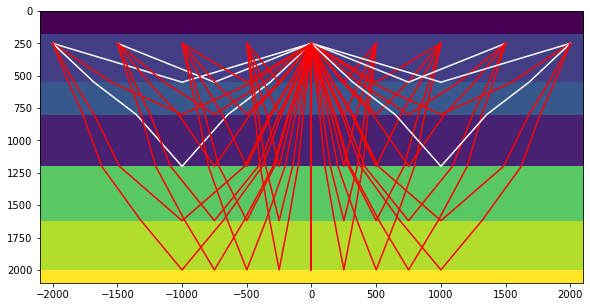

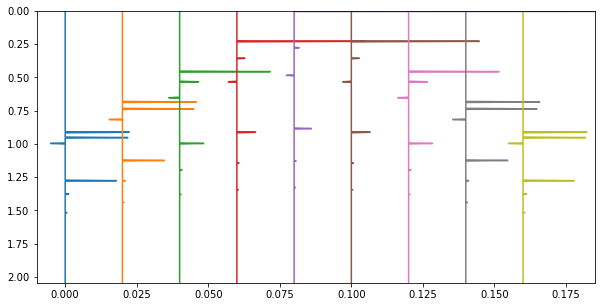

In [81]:
if __name__ == "__main__":
    
    import time
    import matplotlib.pyplot as plt


    ## Define model

    z = np.array([0,180,550,800,1200,1620,2000,2100],dtype=float)
    v = np.array([1800,2200,2400,2000,3440,3750,4000],dtype=float)
    #rho = 1000*0.31*v**0.25# Density based on Gardner's rule
    rho = 2200*np.ones_like(v)
    dz = np.diff(z)
    del z
    assert len(dz) == len(v)
    
    # source / receiver geometry
    x_receivers = np.arange(-2000,2500,500)
    x_source = 0
    z_source = 250
    
    # length and sample rate of recording
    dt = 0.004
    nt = int(2.048/dt)
    
    print (nt)



    start = time.time()
    xs,dzs,vs,ps,rs = model_gather(dz,v,rho,x_source,z_source,x_receivers,dt,nt)
    print("%.4f s"%(time.time()-start))
    
    print(rs.max())    
    
    
    # QC plot
    plt.figure(figsize=(10,5))
    V = np.expand_dims(np.concatenate([v[i]*np.ones(int(dz[i])) for i in range(len(dz))]),-1)
    plt.imshow(V, interpolation="nearest",extent=(np.min([x_source,np.min(x_receivers)])-100,
                                                  np.max([x_source,np.max(x_receivers)])+100,
                                                  V.shape[0],0))
    for xray,dzray,vray,pray in zip(xs,dzs,vs,ps):
        if np.max(pray*vray)>1: color="white"# critical ray
        else: color="red"
        plt.plot(x_source+np.cumsum(np.concatenate([np.zeros(1),xray])),
                 np.cumsum(np.concatenate([np.array([z_source]),dzray])),color=color)
        
    t = np.arange(0,nt,dtype=float)*dt# two-way travel time in seconds
    plt.savefig('./ray_tracing.png',dpi=300,facecolor='w')
    
    
    plt.figure(figsize=(10,5))
    for i,r in enumerate(rs):
        plt.plot(0.02*i+r,t)
        plt.ylim(np.max(t),0)
    plt.xlim(-0.01,0.185)
#     plt.show()
    plt.savefig('./Rt.png',dpi=300,facecolor='w')

    print(r.shape)
    print(rs.shape)
    print(rs[4,0])
    
    rs[4,0] = 0.07
    

In [82]:
source = np.load("../generate_data/gather/source/gather_00000000_00000000.npy")[5]
print(source.shape)

(512,)


In [83]:
conv2d = (rs.T).copy()

print(conv2d.shape)

for ir in range(rs.shape[0]):
    conv2d[:,ir] = 1.5*processing_utils.convolve_source(conv2d[:,ir], source)
    
ss = (conv2d.T).copy()    

(512, 9)


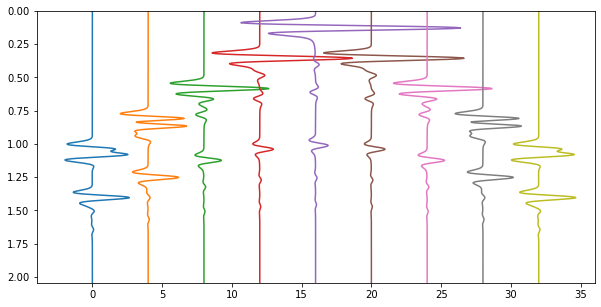

In [84]:
    plt.figure(figsize=(10,5))
    for i,r in enumerate(ss):
        plt.plot(4*i+r,t)
        plt.ylim(np.max(t),0)
    plt.xlim(-4,36)
    plt.savefig('./receiver.png',dpi=300,facecolor='w')